In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
sns.set()
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Stampa il dispositivo in uso
print("Stai utilizzando il dispositivo:", device)

Stai utilizzando il dispositivo: cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


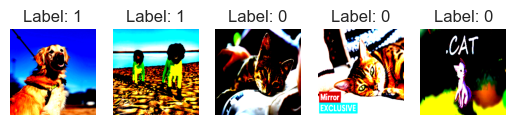

In [2]:

# Funzione per ottenere i loader di addestramento e convalida
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True):
    # Normalizzazione delle immagini
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # Trasformazioni per il set di convalida
    valid_transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        normalize,
    ])

    # Trasformazioni per il set di addestramento

    train_transform = transforms.Compose([
            transforms.Resize((227, 227)),
            transforms.ToTensor(),
            normalize,
        ])

    # Carica il dataset "dogsAndCats" per addestramento e convalida
    train_dataset = datasets.ImageFolder(
        root=data_dir + '/train',  # Cartella del set di addestramento
        transform=train_transform,
    )

    valid_dataset = datasets.ImageFolder(
        root=data_dir + '/train',  # Utilizza la stessa cartella del set di addestramento per la convalida
        transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    # Se richiesto, mescola gli indici
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    # Suddivide gli indici per ottenere gli indici per addestramento e convalida
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # Crea i DataLoader per addestramento e convalida
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,num_workers=4)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,num_workers=4)

    return (train_loader, valid_loader)


# Funzione per ottenere il DataLoader per il set di test
def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    # Normalizzazione delle immagini
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # Trasformazioni per il set di test
    transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        normalize,
    ])

    # Carica il dataset "dogsAndCats" per il test
    test_dataset = datasets.ImageFolder(
        root=data_dir + '/test',  # Cartella del set di test
        transform=transform,
    )

    # Crea il DataLoader per il set di test
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=shuffle,num_workers=4
    )

    return test_loader


# Esempio di utilizzo delle funzioni per ottenere i DataLoader
# dogsAndCats dataset
train_loader, valid_loader = get_train_valid_loader(
    data_dir='C:/Users/Federica/Music/dogsAndCats', batch_size=64,
    augment=True, random_seed=1
)

test_loader = get_test_loader(
    data_dir='C:/Users/Federica/Music/dogsAndCats', batch_size=64
)

# Funzione per visualizzare alcune immagini dal DataLoader
def show_images(loader, num_images=5):
    # Ottieni un iteratore dal DataLoader
    data_iter = iter(loader)

    # Estrai il prossimo batch dal DataLoader
    images, labels = next(data_iter)

    # Visualizza le immagini e le relative etichette
    for i in range(num_images):
        image = images[i].numpy().transpose((1, 2, 0))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

# Visualizza alcune immagini dal DataLoader di addestramento
show_images(train_loader)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Definizione del blocco base della ResNet
class BasicBlock(nn.Module):
    # expansion è un parametro che scala la dimensione dell'output del blocco
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        
        #andiamo a creare il blocco base resNET
        
        # Primo strato convoluzionale
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)  # Batch normalization dopo il primo strato
        # Secondo strato convoluzionale
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)  # Batch normalization dopo il secondo strato

        # Connessione shortcut per gestire gli input se c'è un cambio di dimensione
        self.shortcut = nn.Sequential()
        #Se la condizione è verificata, viene creata una connessione shortcut tramite un modulo Sequential
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))  # Applicazione ReLU dopo il primo strato convoluzionale
        out = self.bn2(self.conv2(out))  # Applicazione Batch Normalization dopo il secondo strato convoluzionale
        out += self.shortcut(x)  # Aggiunta della shortcut connection
        out = F.relu(out)  # Applicazione ReLU dopo l'aggiunta della shortcut connection
        return out

# Definizione dell'architettura ResNet-18
class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        # Primo strato convoluzionale seguito da Batch Normalization
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Definizione dei vari livelli della rete utilizzando i blocchi base
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        # Global Average Pooling (GAP) per ridurre le dimensioni spaziali
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes)

    # Metodo per creare un singolo livello della rete usando il blocco base
    def _make_layer(self, block, planes, num_blocks, stride):
    # Creazione di una lista di stride per ogni blocco nel livello
    strides = [stride] + [1] * (num_blocks - 1)
    
    # Lista che conterrà i blocchi del livello
    layers = []

    # Ciclo attraverso ogni stride e crea un blocco per ciascuno
    for stride in strides:
        # Aggiungi il blocco alla lista 'layers'
        layers.append(block(self.in_planes, planes, stride))
        
        # Aggiorna il numero di canali 'in_planes' per il prossimo blocco
        self.in_planes = planes * block.expansion

    # Restituisci i blocchi come un livello sequenziale
    return nn.Sequential(*layers)


    # Passaggio in avanti attraverso la rete
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [4]:
# Numero di classi nel problema di classificazione
num_classes = 2

# Numero di epoche per l'addestramento
num_epochs = 20

# Dimensione del batch durante l'addestramento
batch_size = 64

# Tasso di apprendimento per l'ottimizzatore
learning_rate = 0.001

# Creazione di un'istanza del modello e spostamento del modello sulla GPU (se disponibile)
model = ResNet18(num_classes).to(device)

# Definizione della funzione di perdita (cross-entropy) e dell'ottimizzatore (Stochastic Gradient Descent - SGD)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.005, momentum=0.9)

# Numero totale di passaggi (batches) nell'addestramento, determinato dalla lunghezza del DataLoader di addestramento
total_step = len(train_loader)


In [5]:
# Ciclo sul numero di epoche specificato
for epoch in range(num_epochs):
    # Ciclo su ogni batch nel DataLoader di addestramento
    for i, (images, labels) in enumerate(train_loader):  
        # Sposta i tensori sul dispositivo configurato (GPU o CPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calcola la perdita utilizzando la funzione di perdita definita in precedenza (CrossEntropyLoss)
        loss = criterion(outputs, labels)
        
        # Backward pass e ottimizzazione dei pesi
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Stampa l'informazione sull'andamento dell'addestramento (epoca corrente, passaggio corrente, perdita corrente)
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validazione del modello
    with torch.no_grad():
        correct = 0
        total = 0
        # Ciclo su ogni batch nel DataLoader di convalida
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            # Calcola le predizioni e la precisione del modello sulla convalida
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Libera memoria rimuovendo i tensori temporanei
            del images, labels, outputs
    
        # Stampa l'accuratezza del modello sulla convalida
        print('Accuracy of the network on the {} validation images: {} %'.format(len(valid_loader.dataset), 100 * correct / total))
 

Epoch [1/20], Step [8/8], Loss: 0.8416
Accuracy of the network on the 557 validation images: 61.81818181818182 %
Epoch [2/20], Step [8/8], Loss: 0.6633
Accuracy of the network on the 557 validation images: 69.0909090909091 %
Epoch [3/20], Step [8/8], Loss: 0.7217
Accuracy of the network on the 557 validation images: 69.0909090909091 %
Epoch [4/20], Step [8/8], Loss: 0.6297
Accuracy of the network on the 557 validation images: 67.27272727272727 %
Epoch [5/20], Step [8/8], Loss: 0.7252
Accuracy of the network on the 557 validation images: 65.45454545454545 %
Epoch [6/20], Step [8/8], Loss: 0.6585
Accuracy of the network on the 557 validation images: 72.72727272727273 %
Epoch [7/20], Step [8/8], Loss: 0.5106
Accuracy of the network on the 557 validation images: 67.27272727272727 %
Epoch [8/20], Step [8/8], Loss: 0.4544
Accuracy of the network on the 557 validation images: 72.72727272727273 %
Epoch [9/20], Step [8/8], Loss: 0.4931
Accuracy of the network on the 557 validation images: 78.18

Precision on the 140 test images: 0.64
Recall on the 140 test images: 0.64
Accuracy on the 140 test images: 0.64


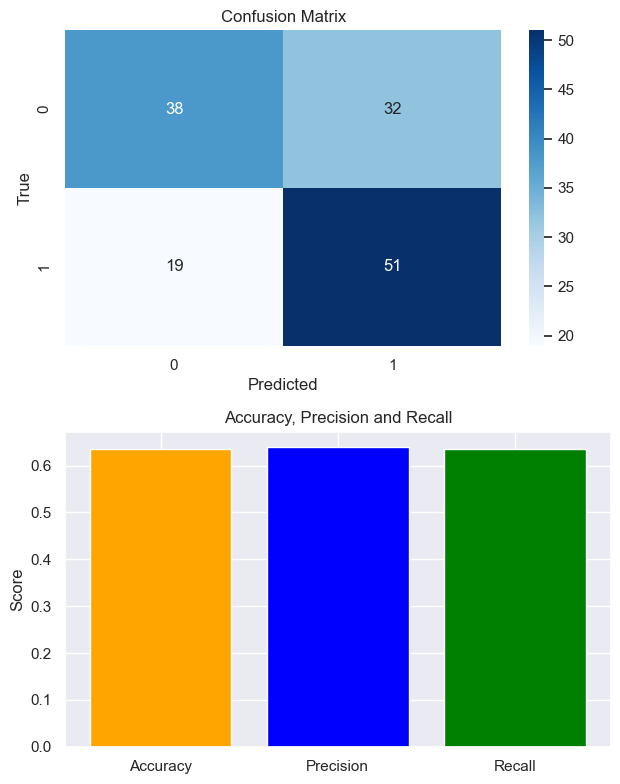

In [6]:


# Test del modello su dati di test
with torch.no_grad():
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []

    # Ciclo su ogni batch nel DataLoader di test
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # Ottieni le predizioni e calcola le metriche di valutazione
        _, predicted = torch.max(outputs.data, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Libera memoria rimuovendo i tensori temporanei
        del images, labels, outputs

    # Calcola precision, recall e accuracy
    test_precision = precision_score(all_labels, all_predicted, average='weighted')
    test_recall = recall_score(all_labels, all_predicted, average='weighted')
    test_accuracy = accuracy_score(all_labels, all_predicted)
    
    # Stampa le metriche di valutazione
    print('Precision on the {} test images: {:.2f}'.format(total, test_precision))
    print('Recall on the {} test images: {:.2f}'.format(total, test_recall))
    print('Accuracy on the {} test images: {:.2f}'.format(total, test_accuracy))

    # Calcola la confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predicted)
    
    # Visualizza la confusion matrix
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=list(range(2)), yticklabels=list(range(2)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Visualizza gli istogrammi di precision e recall
    plt.subplot(2, 2, 3)
    plt.bar(['Accuracy', 'Precision', 'Recall'], [test_accuracy, test_precision, test_recall], color=['orange', 'blue', 'green'])
    plt.ylabel('Score')
    plt.title('Accuracy, Precision and Recall')

    # Aggiusta la disposizione dei subplot
    plt.tight_layout()
    
    # Mostra i grafici
    plt.show()
